#Latent Semantic Analysis:

Application
------------------------

Document clustering, Information retrieval and Recommendation, Understand large scale unstructured data, text classification

Topic Modeling
------------------------
Discover hidden themes (group of words) from given documents.

LSA
------------------------
- Also known as *latent semantic index(LSI)*
- use `bag-of-word` (BoW), result in `term-document matrix` (Rows: terms; Columns: documents)
- decomposition method: single value decomposition (SVD)

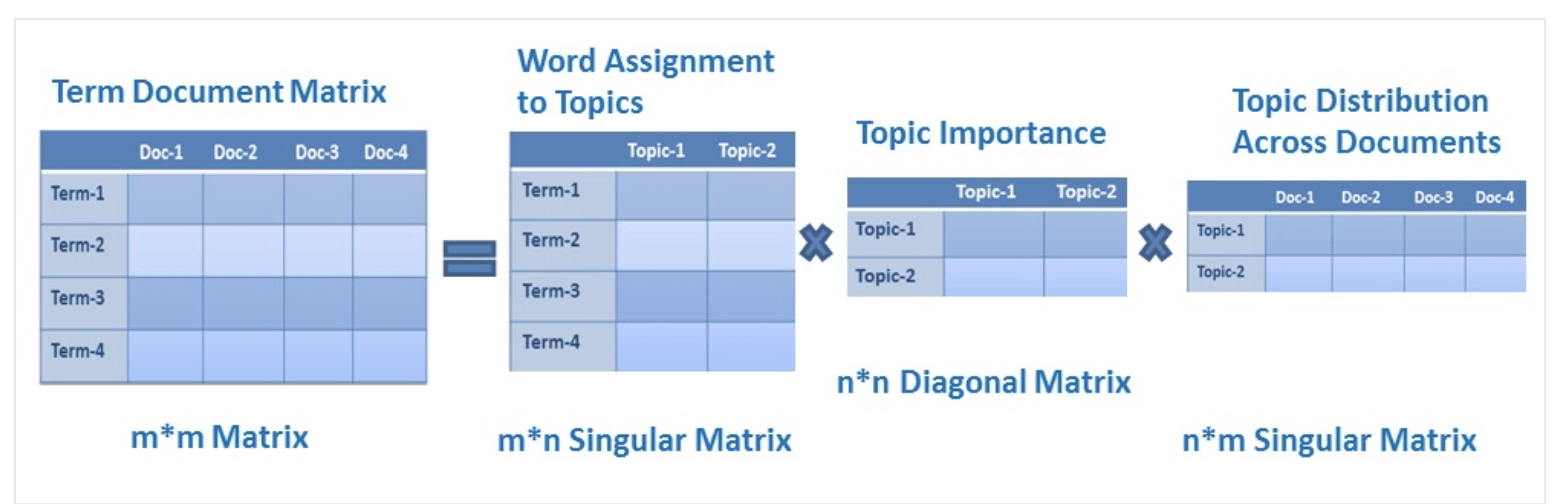

Singular Value Decomposition
-------------------------------
- matrix factorization: 
  - A matrix of two matrices product
  - By mapping a large number of terms to a smaller number of latent factors, the feature space is greatly reduced.
  - Formular:
#       M=U𝛴V*
     - M: m*m matrix,define word-word relationship
     - U: m*n left singular matrix, define word-document relationship
     - 𝛴: n*n diagonal matrix with non-negative real numbers.
     - V: m*n right singular matrix, define document-document relationship
  - Identity matrix: Square matrix, diagonal elements=1, others=0;
  - Diagonal Matrix:the entries other than the main diagonal are all zero.
  - Singular Matrix: A matrix is singular if its *determinant* is 0 or a square matrix that does *not have a matrix inverse.*

In [3]:
#import python library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import nltk
import re
#set the column width for data review
pd.set_option("display.max_colwidth", 200)

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

In [4]:
#import dataset: https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html
from sklearn.datasets import fetch_20newsgroups

In [5]:
#select and use part of dataset 
dataset=fetch_20newsgroups(shuffle=True,random_state=1,remove=('headers','footers','quotes'),subset='train')

In [6]:
# len of training and testing dataset
print("Length of data:", len(dataset.data))

Length of data: 11314


In [7]:
dataset.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

# EDA

In [8]:
# put important columns into dataframe
news_df = pd.DataFrame({'News': dataset.data,
                        'Target': dataset.target})

In [9]:
news_df.shape

(11314, 2)

In [10]:
news_df.head()

,News,Target
0,Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe...,17
1,"\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism? No, you need a little leap of faith, Jimmy. Your logic runs out\nof steam!\n\n\n\n\n\n\n\nJim,\n...",0
2,"Although I realize that principle is not one of your strongest\npoints, I would still like to know why do do not ask any question\nof this sort about the Arab countries.\n\n If you want to conti...",17
3,"Notwithstanding all the legitimate fuss about this proposal, how much\nof a change is it? ATT's last product in this area (a) was priced over\n$1000, as I suspect 'clipper' phones will be; (b) ca...",11
4,"Well, I will have to change the scoring on my playoff pool. Unfortunately\nI don't have time right now, but I will certainly post the new scoring\nrules by tomorrow. Does it matter? No, you'll ...",10


In [11]:
#add target name into the dataframe
news_df['Target_name'] = news_df['Target'].apply(lambda x: dataset.target_names[x])

In [12]:
news_df.head()

,News,Target,Target_name
0,Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe...,17,talk.politics.mideast
1,"\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism? No, you need a little leap of faith, Jimmy. Your logic runs out\nof steam!\n\n\n\n\n\n\n\nJim,\n...",0,alt.atheism
2,"Although I realize that principle is not one of your strongest\npoints, I would still like to know why do do not ask any question\nof this sort about the Arab countries.\n\n If you want to conti...",17,talk.politics.mideast
3,"Notwithstanding all the legitimate fuss about this proposal, how much\nof a change is it? ATT's last product in this area (a) was priced over\n$1000, as I suspect 'clipper' phones will be; (b) ca...",11,sci.crypt
4,"Well, I will have to change the scoring on my playoff pool. Unfortunately\nI don't have time right now, but I will certainly post the new scoring\nrules by tomorrow. Does it matter? No, you'll ...",10,rec.sport.hockey


Text(0.5, 0, 'Count of topics')

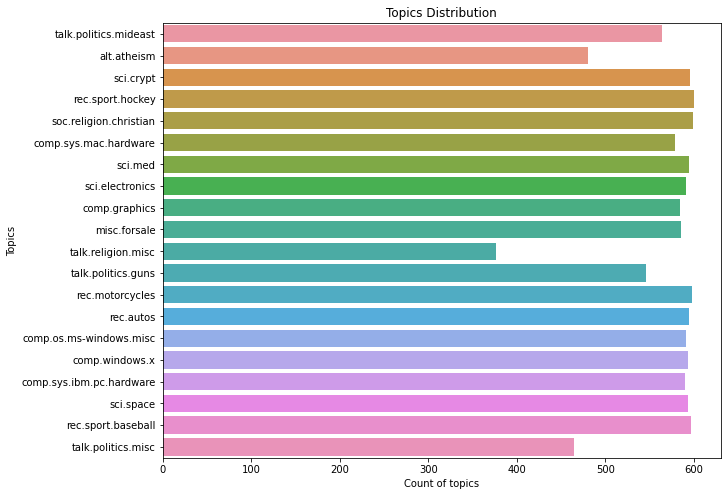

In [13]:
#get the plot distribution
fig = plt.figure(figsize=[10,8])
ax = sns.countplot(y=news_df['Target_name'])
plt.title('Topics Distribution')
plt.ylabel('Topics')
plt.xlabel('Count of topics')

# Text Preprocessing

In [14]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [15]:
#set up a funtion for text cleaning
def clean_text(sentence):
    pattern = re.compile(r'[^a-z]+')                                            #remove alphabetic                     
    sentence = sentence.lower()                                                 #set words into lowercase
    sentence = pattern.sub(' ', sentence).strip()                               #remove any space at beginning and ending
    wordlist=word_tokenize(sentence)                                            #tokenization break up into individual words
    stopwords_list=set(stopwords.words('english'))                              #get stopwords lists
    wordlist = [word for word in wordlist if word not in stopwords_list]        #remove stopwords from word lists
    wordlist = [word for word in wordlist if len(word) > 2]                     #remove small length words
    lemma = WordNetLemmatizer()                                                 #lemmatization use wordnet
    wordlist = [lemma.lemmatize(word) for word in wordlist]
    sentence = ' '.join(wordlist)                                               #combine wordslist into sentence with space
    return sentence


In [16]:
#apply the text cleaning funtion to dataset
news_df['News'] = news_df['News'].apply(lambda x: clean_text(str(x)))

In [17]:
#check the after-cleaning result
news_df.head()

,News,Target,Target_name
0,well sure story nad seem biased disagree statement medium ruin israel reputation rediculous medium pro israeli medium world lived europe realize incidence one described letter occured medium whole...,17,talk.politics.mideast
1,yeah expect people read faq etc actually accept hard atheism need little leap faith jimmy logic run steam jim sorry pity jim sorry feeling denial faith need get well pretend end happily ever anywa...,0,alt.atheism
2,although realize principle one strongest point would still like know ask question sort arab country want continue think tank charade fixation israel must stop might start asking sort question arab...,17,talk.politics.mideast
3,notwithstanding legitimate fuss proposal much change att last product area priced suspect clipper phone came customer key automatically preregistered government authority thus aside attempting leg...,11,sci.crypt
4,well change scoring playoff pool unfortunately time right certainly post new scoring rule tomorrow matter enter anyway good keith keller let ranger let quaker kkeller mail sa upenn edu ivy league ...,10,rec.sport.hockey


In [49]:
#vectorized text data into numerical info. use tfidf method get document-term matrix,describe the frequency of terms occurrence
#for tf-idf method,less occurrence, more important the word is
tfidf_vector = TfidfVectorizer(tokenizer=lambda x: str(x).split(),
                                               stop_words='english',
                                               max_df=0.95, 
                                               min_df=2,
                                               max_features=1000,
                                               smooth_idf=True)
X = tfidf_vector.fit_transform(news_df['News'])

In [50]:
#check the shape of DTM
X.shape

(11314, 1000)

# LSA Modeling

In [20]:
#TruncatedSVD to perform the task of matrix decomposition
#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
svd= TruncatedSVD(n_components=20,            #set 20 topics
                  algorithm='randomized',
                  n_iter=100,
                  random_state=122)     

In [21]:
#Fit model on training data X
svd.fit(X)

TruncatedSVD(n_components=20, n_iter=100, random_state=122)

In [22]:
#check the shape of matrix,we will get (n_components, n_features) for right singular vectors of the input data.
svd.components_.shape

(20, 1000)

In [48]:
len(svd.components_)

20

In [23]:
# document-topic mapping matrix
doc_topic = svd.fit_transform(X)        #fit model to X and perform dimensionality reduction on X.
doc_topic.shape

(11314, 20)

In [24]:
#Get output feature names for transformation
feature = tfidf_vector.get_feature_names() 

In [25]:
# function to map words to topics
def map_word2topic(components, terms):
    word2topics = pd.Series()                        #change output into pandas series
    for idx, component in enumerate(components):     # map feature (words) with topic
        feature_topic = pd.Series(component, index=feature)       # probability of word given a topic P(w|t)
        feature_topic.sort_values(ascending=False, inplace=True)  # sort values based on probability
        word2topics['topic '+str(idx)] = list(feature_topic.iloc[:5].index)
    return word2topics

In [26]:
#show the important words of each topic
word2topics = map_word2topic(svd.components_, feature)
# print topic results
print('Topics\t\tWords')
for idx, feature in zip(word2topics.index, word2topics):
    print(idx,'\t',feature)

Topics		Words
topic 0 	 ['would', 'one', 'like', 'know', 'get']
topic 1 	 ['window', 'file', 'thanks', 'card', 'drive']
topic 2 	 ['game', 'team', 'year', 'player', 'season']
topic 3 	 ['drive', 'key', 'car', 'chip', 'scsi']
topic 4 	 ['thanks', 'please', 'drive', 'god', 'anyone']
topic 5 	 ['drive', 'god', 'window', 'card', 'problem']
topic 6 	 ['key', 'game', 'god', 'chip', 'team']
topic 7 	 ['edu', 'com', 'year', 'sale', 'file']
topic 8 	 ['drive', 'file', 'would', 'people', 'disk']
topic 9 	 ['card', 'people', 'armenian', 'driver', 'video']
topic 10 	 ['would', 'edu', 'like', 'think', 'bank']
topic 11 	 ['edu', 'know', 'get', 'think', 'file']
topic 12 	 ['edu', 'window', 'drive', 'key', 'car']
topic 13 	 ['file', 'car', 'card', 'driver', 'would']
topic 14 	 ['one', 'game', 'like', 'file', 'bike']
topic 15 	 ['one', 'edu', 'problem', 'would', 'car']
topic 16 	 ['com', 'problem', 'car', 'gun', 'please']
topic 17 	 ['get', 'game', 'god', 'armenian', 'problem']
topic 18 	 ['com', 'like

In [27]:
def get_top3_topics(x):
    top3 = list(x.sort_values(ascending=False).head(3).index) + list(x.sort_values(ascending=False).head(3).values)
    return top3

In [28]:
# map top3 topic words to news document
def map_topicword2doc(model, X):
    # output data frame column list
    cols = ['topic_'+str(i+1)+'_name' for i in range(3)] + ['topic_'+str(i+1)+'_prob' for i in range(3)]
    # doc to topic mapping
    doc_topic = model.fit_transform(X)
    # list of topics
    topics = ['topic'+str(i) for i in range(20)]
    # doc topic data frame
    doc_topic_df = pd.DataFrame(doc_topic, columns=topics)
    # map top 3 topics to doc
    outdf = doc_topic_df.apply(lambda x: get_top3_topics(x), axis=1)
    # outdf is a series of list
    # convert it to a data frame
    outdf = pd.DataFrame(dict(zip(outdf.index, outdf.values))).T
    outdf.columns = cols
    
    return outdf

In [29]:
top_topics = map_topicword2doc(svd, X)
news_topics = pd.concat([news_df, top_topics], axis=1)

In [30]:
# convert probability from string to float
news_topics = news_topics.infer_objects() #attempt to infer better dtypes for object columns.

In [31]:
news_topics.head(2)

,News,Target,Target_name,topic_1_name,topic_2_name,topic_3_name,topic_1_prob,topic_2_prob,topic_3_prob
0,well sure story nad seem biased disagree statement medium ruin israel reputation rediculous medium pro israeli medium world lived europe realize incidence one described letter occured medium whole...,17,talk.politics.mideast,topic0,topic9,topic14,0.151742,0.124693,0.063884
1,yeah expect people read faq etc actually accept hard atheism need little leap faith jimmy logic run steam jim sorry pity jim sorry feeling denial faith need get well pretend end happily ever anywa...,0,alt.atheism,topic0,topic5,topic12,0.168244,0.039020,0.032083


Text(0.5, 0, 'Count of topic 1')

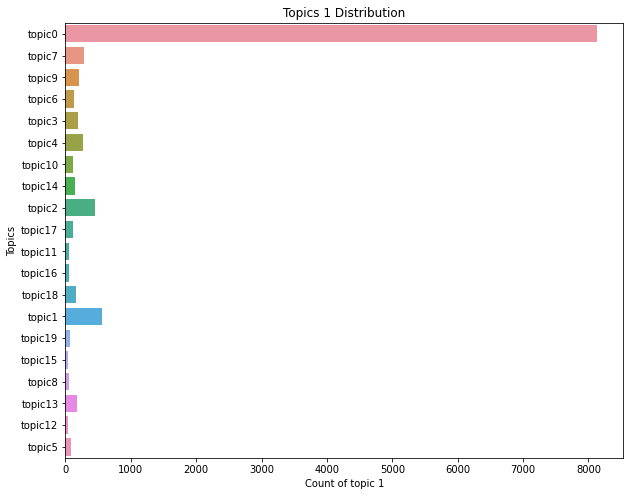

In [32]:
#visualiztion
fig = plt.figure(figsize=[10,8])
ax = sns.countplot(y=news_topics['topic_1_name'])
plt.title('Topics 1 Distribution')
plt.ylabel('Topics')
plt.xlabel('Count of topic 1')

Text(0.5, 0, 'Count of topic 2')

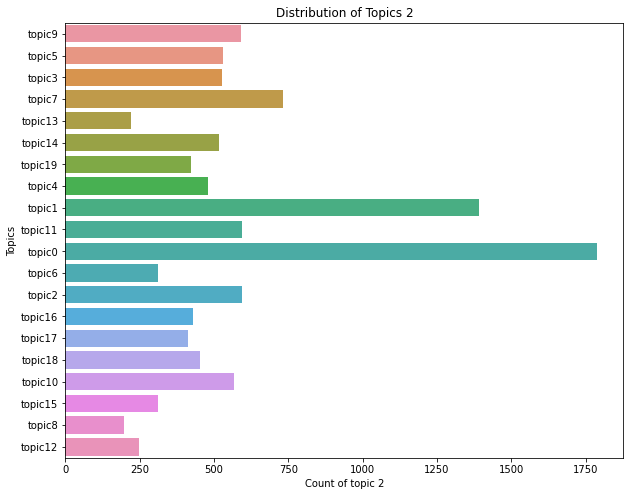

In [33]:
fig = plt.figure(figsize=[10,8])
ax = sns.countplot(y=news_topics['topic_2_name'])
plt.title('Distribution of Topics 2')
plt.ylabel('Topics')
plt.xlabel('Count of topic 2')

Text(0.5, 0, 'Count of topic 3')

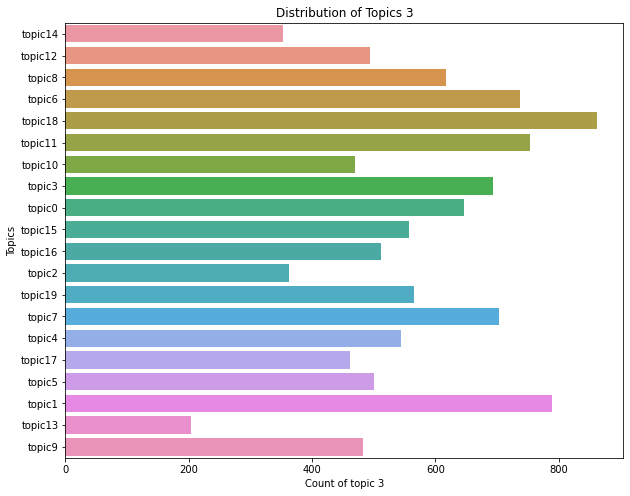

In [34]:
fig = plt.figure(figsize=[10,8])
ax = sns.countplot(y=news_topics['topic_3_name'])
plt.title('Distribution of Topics 3')
plt.ylabel('Topics')
plt.xlabel('Count of topic 3')

In [35]:
X_topics = svd.fit_transform(X)

In [38]:
X_topics.shape

(11314, 20)